In [1]:
import numpy as np
# import numpy.random
import torch
# import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F


from generate_sample_EIT import sample_train, sample_test
from model import net_u, net_v, net_a, fun_w, fun_g, grad_u, grad_v
#from loss import wan_loss, drm_loss, pinn_loss
from inv_loss import idrm_eit_loss, iPINN_eit_loss
from others import tensor_to_numpy
from set_train_params import set_params, set_params_pinn, set_params_drm
from evaluation import visual_net

C:\Users\Guang\anaconda3\lib\site-packages\torch\nn\functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\Guang\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0-th iteration
loss: tensor(6.1851e+08, device='cuda:0', grad_fn=<AddBackward0>)


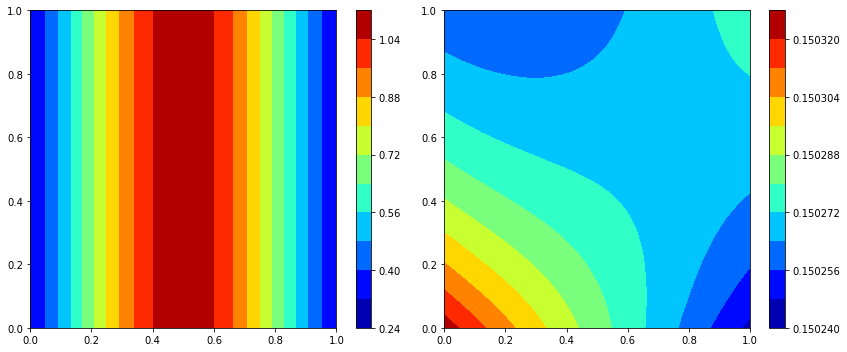

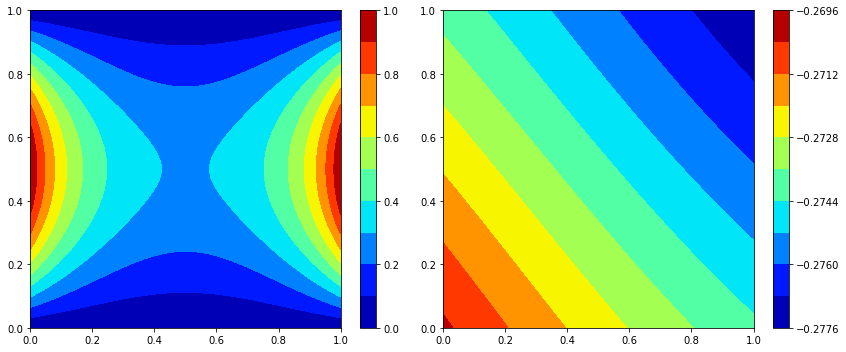

500-th iteration
loss: tensor(90106344., device='cuda:0', grad_fn=<AddBackward0>)


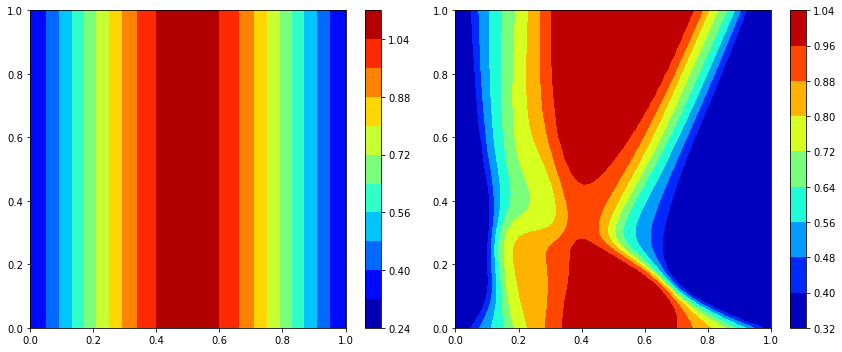

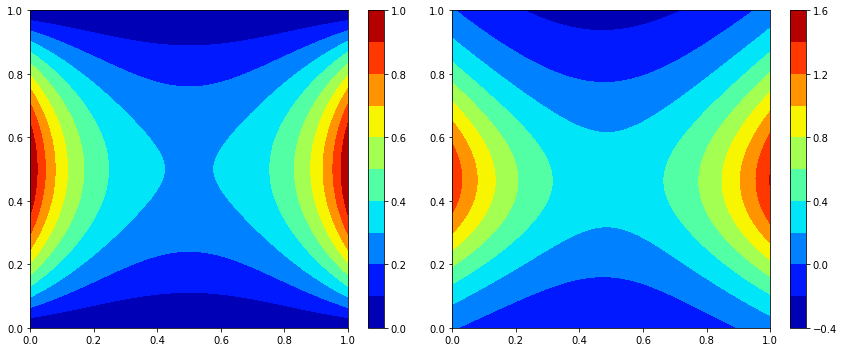

1000-th iteration
loss: tensor(78369624., device='cuda:0', grad_fn=<AddBackward0>)


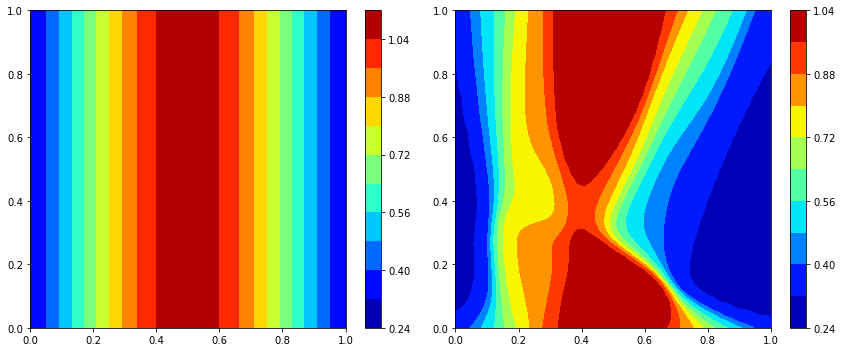

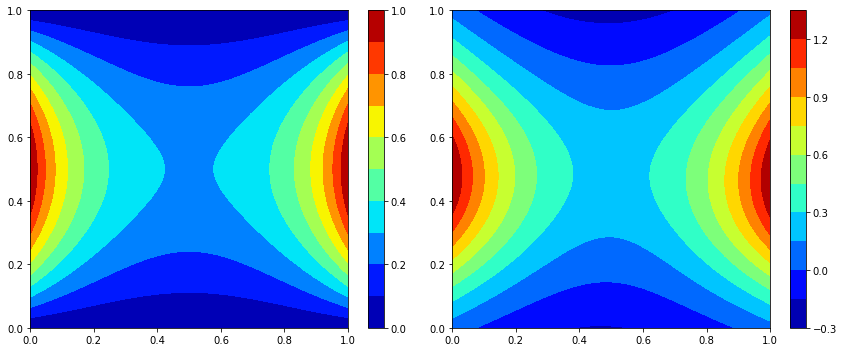

1500-th iteration
loss: tensor(67789984., device='cuda:0', grad_fn=<AddBackward0>)


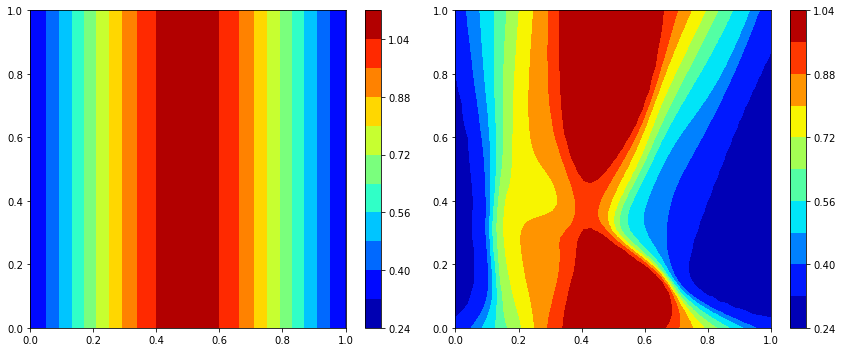

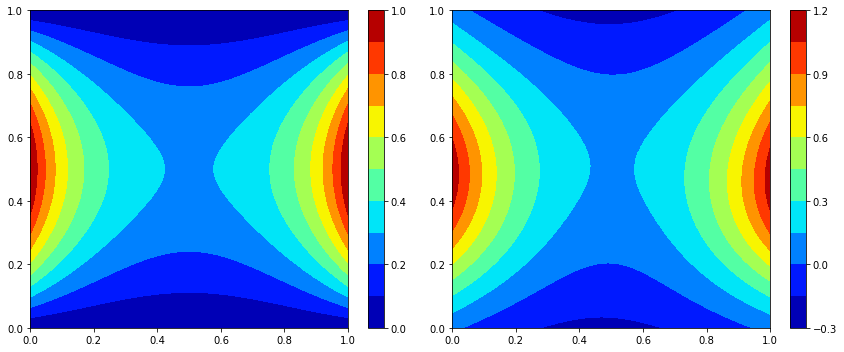

2000-th iteration
loss: tensor(63384224., device='cuda:0', grad_fn=<AddBackward0>)


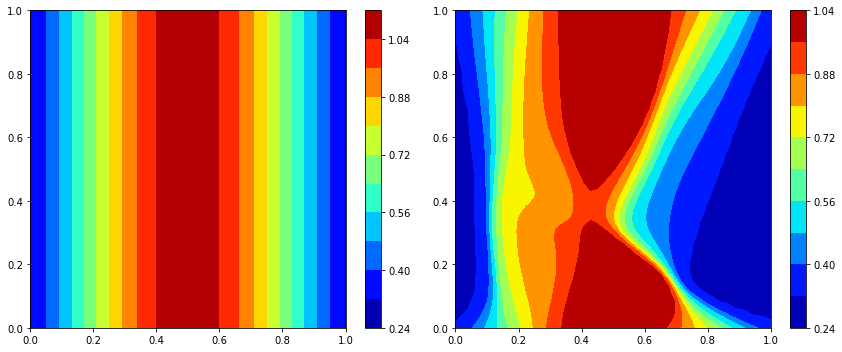

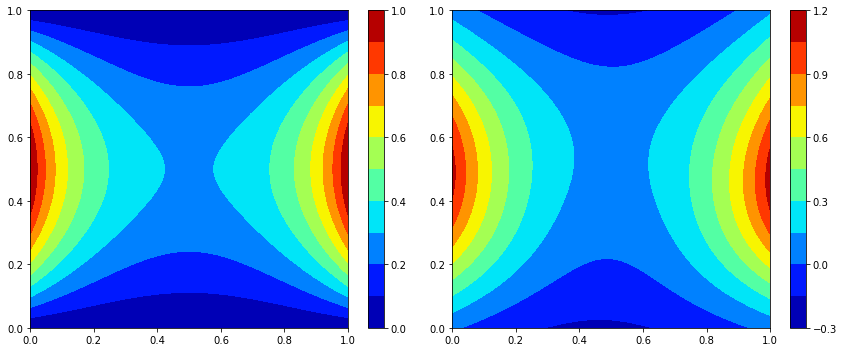

2500-th iteration
loss: tensor(57866872., device='cuda:0', grad_fn=<AddBackward0>)


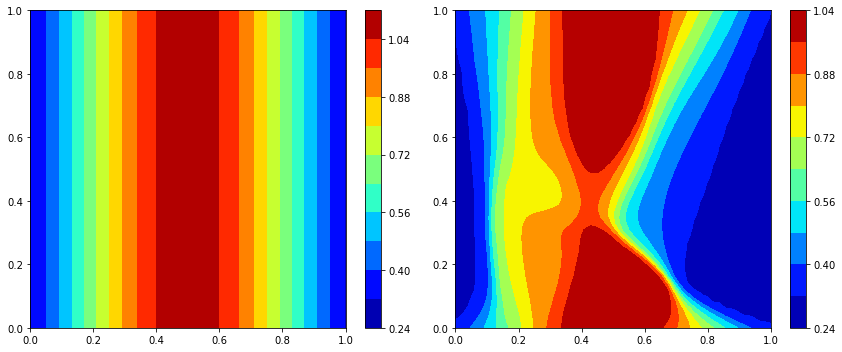

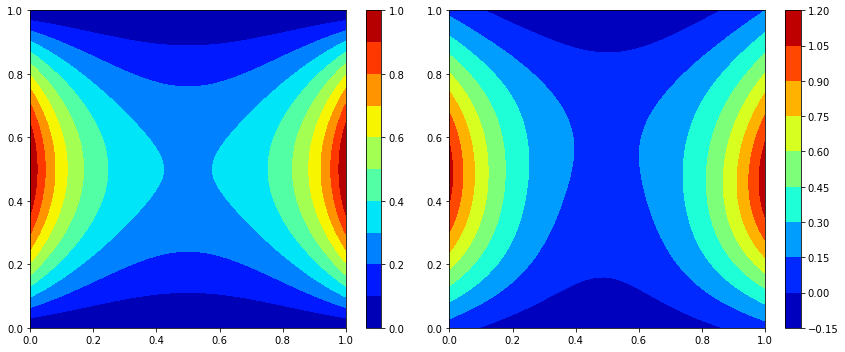

In [2]:
torch.manual_seed(20)

torch.set_default_tensor_type('torch.FloatTensor')
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')

params = set_params_drm(dim=2)

layer= 3; neuron= 20

u_rate = 0.01
a_rate = 0.2

niters = 2000 + 1

u = net_u(neuron, layer).to(device)
a = net_a(neuron, layer).to(device)

optimizerU = optim.Adagrad(u.parameters(), lr=u_rate)
optimizerA = optim.Adagrad(a.parameters(), lr=a_rate)


n_rec = 50
err_rec = np.zeros(int(niters/n_rec))

step = []; err_u = []; err_a = []
visual=visual_net(params)
for i in range(niters):
    # u step
    for p in u.parameters():  # reset requires_grad
        p.requires_grad = True     
    for p in a.parameters():
        p.requires_grad = False


    for _ in range(params['u_steps']):
        train_dict = sample_train(params)
        x = train_dict['x_dm']
        x_bd = train_dict['x_bd']
        x = torch.tensor(x, requires_grad=True).to(device)
        x_bd = torch.tensor(x_bd, requires_grad=True).to(device)
        int_dm = train_dict['int_dm']
        
        a_bd = train_dict['a_bd']
        u_bd = train_dict['u_bd']
        a_bd = torch.Tensor(a_bd).to(device)
        u_bd = torch.Tensor(u_bd).to(device)
        n_vec = train_dict['n_vector']
        n_vec = torch.Tensor(n_vec).to(device)

        optimizerU.zero_grad()
        loss = idrm_eit_loss(u, a, x, x_bd, n_vec, u_bd, a_bd, params)        
        loss.backward()
        optimizerU.step()


    for p in u.parameters():  # reset requires_grad
        p.requires_grad = False     
    for p in a.parameters():
        p.requires_grad = True

        train_dict = sample_train(params)
        x = train_dict['x_dm']
        x_bd = train_dict['x_bd']
        x = torch.tensor(x, requires_grad=True).to(device)
        x_bd = torch.tensor(x_bd, requires_grad=True).to(device)
        int_dm = train_dict['int_dm']
        a_bd = train_dict['a_bd']
        u_bd = train_dict['u_bd']
        a_bd = torch.Tensor(a_bd).to(device)
        u_bd = torch.Tensor(u_bd).to(device)
        n_vec = train_dict['n_vector']
        n_vec = torch.Tensor(n_vec).to(device)

    for _ in range(params['a_steps']):        
        optimizerA.zero_grad()
        loss = iPINN_eit_loss(u, a, x, x_bd, n_vec, u_bd, a_bd, params)        
        loss.backward()
        optimizerA.step()

    if i%5==0:
        test_dict = sample_test(params)
        x_test = test_dict['test_x']
        x_test = torch.tensor(x_test, requires_grad=True).to(device)
        pred_u, _, div_du = grad_u(u, x_test, True)
        pred_u = pred_u.cpu().detach().numpy()
        div_du = div_du.cpu().detach().numpy()
        pred_a = a(x_test)
        pred_a = pred_a.cpu().detach().numpy()
        total_u= np.sqrt(np.mean(np.square(test_dict['test_u'])))
        total_a= np.sqrt(np.mean(np.square(test_dict['test_u'])))
        step.append(i+1)
        err_u.append(np.sqrt(np.mean(np.square(test_dict['test_u']-pred_u)))/total_u)
        err_a.append(np.sqrt(np.mean(np.square(test_dict['test_a']-pred_a)))/total_a)
        
    if i%500==0:
        print('{}-th iteration'.format(i))
        print('loss:', loss)
        test_dict = sample_test(params)
        mesh = test_dict['mesh']
        x_draw = test_dict['draw_x']; u_draw = test_dict['draw_u']; a_draw = test_dict['draw_a']
        x_draw = torch.tensor(x_draw, requires_grad=True).to(device)
        pred_u_draw = u(x_draw); pred_a_draw = a(x_draw)
        pred_u_draw = tensor_to_numpy(pred_u_draw); pred_a_draw = tensor_to_numpy(pred_a_draw)
        visual.show_u_val(mesh, a_draw, pred_a_draw, 'a',  i)
        visual.show_u_val(mesh, u_draw, pred_u_draw, 'u',  i)



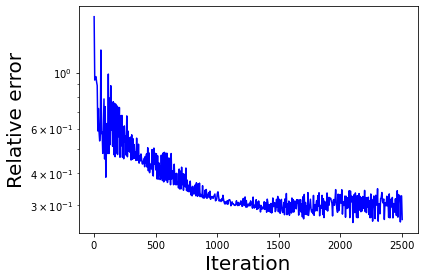

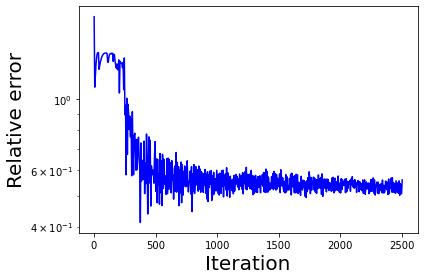

In [4]:
visual.show_error(step, err_u, params['dim'], 'l2r_u')
visual.show_error(step, err_a, params['dim'], 'l2r_a')

In [7]:
from scipy.io import savemat

drm_error = {}
drm_error['drm_err_a'] = err_a
drm_error['drm_err_u'] = err_u
savemat('drm_error.mat', drm_error)

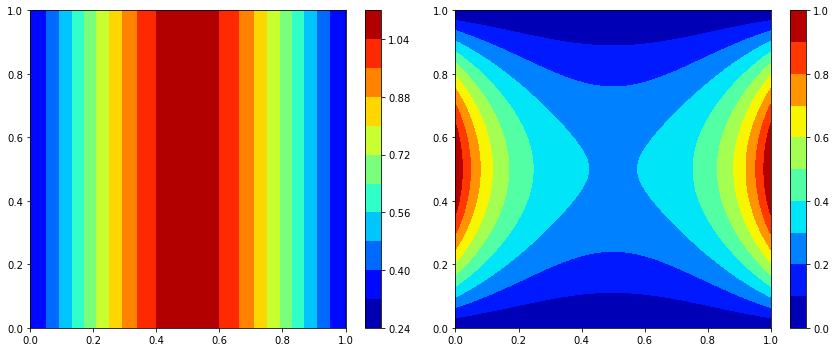

In [18]:
import matplotlib.pyplot as plt
from matplotlib import cm

x1, x2 = mesh
mesh_size = 50
z1, z2 = a_draw, u_draw
z1= np.reshape(z1, [mesh_size, mesh_size])
z2= np.reshape(z2, [mesh_size, mesh_size])
#*******************
fig= plt.figure(figsize=(12,5))
ax1= fig.add_subplot(1,2,1)
graph1= ax1.contourf(x1, x2, z1, 10,  cmap= cm.jet)
fig.colorbar(graph1, ax= ax1)
#
ax2= fig.add_subplot(1,2,2)
graph2= ax2.contourf(x1, x2, z2, 10,  cmap= cm.jet)
fig.colorbar(graph2, ax= ax2)
#*******************
plt.tight_layout()
plt.savefig('gt.png')
plt.show()
# plt.savefig(self.dir+'figure_%s/%s_val_%d.png'%(name, name, i))
plt.close()

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm

x1, x2 = mesh
mesh_size = 50
z1, z2 = pred_a_draw, pred_u_draw
z1= np.reshape(z1, [mesh_size, mesh_size])
z2= np.reshape(z2, [mesh_size, mesh_size])
#*******************
fig= plt.figure(figsize=(12,5))
ax1= fig.add_subplot(1,2,1)
graph1= ax1.contourf(x1, x2, z1, 10,  cmap= cm.jet)
fig.colorbar(graph1, ax= ax1)
#
ax2= fig.add_subplot(1,2,2)
graph2= ax2.contourf(x1, x2, z2, 10,  cmap= cm.jet)
fig.colorbar(graph2, ax= ax2)
#*******************
plt.tight_layout()
plt.savefig('drm_result.png')
plt.show()
# plt.savefig(self.dir+'figure_%s/%s_val_%d.png'%(name, name, i))
plt.close()

NameError: name 'mesh' is not defined